<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Comparativa/red_neuronal_recurrente_anual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
#import keras_tuner

In [4]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modo_1["Fecha"] = pd.to_datetime(modo_1["Fecha"],format='%Y-%m-%d')
modo_2["Fecha"] = pd.to_datetime(modo_2["Fecha"],format='%Y-%m-%d')
modo_3["Fecha"] = pd.to_datetime(modo_3["Fecha"],format='%Y-%m-%d')
modo_4["Fecha"] = pd.to_datetime(modo_4["Fecha"],format='%Y-%m-%d')
modo_5["Fecha"] = pd.to_datetime(modo_5["Fecha"],format='%Y-%m-%d')
residuo["Fecha"] = pd.to_datetime(residuo["Fecha"],format='%Y-%m-%d')
modo_1.set_index("Fecha", inplace=True)
modo_2.set_index("Fecha", inplace=True)
modo_3.set_index("Fecha", inplace=True)
modo_4.set_index("Fecha", inplace=True)
modo_5.set_index("Fecha", inplace=True)
residuo.set_index("Fecha", inplace=True)

In [5]:
modo_1 = modo_1.asfreq('D')
modo_2 = modo_2.asfreq('D')
modo_3 = modo_3.asfreq('D')
modo_4 = modo_4.asfreq('D')
modo_5 = modo_5.asfreq('D')
residuo = residuo.asfreq('D')
modo_1.interpolate(inplace=True)
modo_2.interpolate(inplace=True)
modo_3.interpolate(inplace=True)
modo_4.interpolate(inplace=True)
modo_5.interpolate(inplace=True)
residuo.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

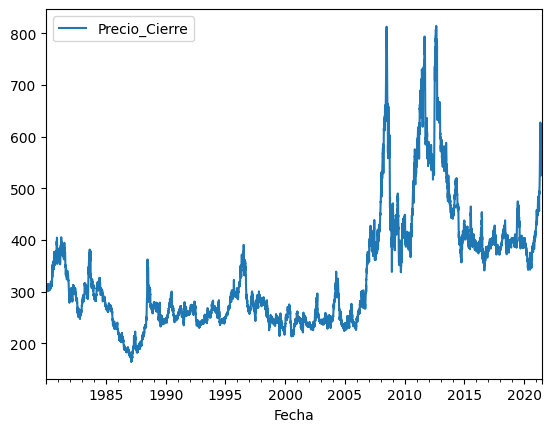

In [6]:
datos_emd = modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
datos_emd.plot()

In [7]:
datos_emd.describe()

,Precio_Cierre
count,15155.000000
mean,334.254726
std,115.387240
min,164.250000
25%,249.000000
50%,290.250000
75%,395.000000
max,814.500000


In [8]:
def  create_features ( df ):
    """
    Crea características de series de tiempo basadas en el índice de series de tiempo.
    """
    df = df.copy()
    df[ 'diasemana' ] = df.index.dayofweek
    df[ 'trimestre' ] = df.index.quarter
    df[ 'mes' ] = df.index.month
    df[ 'año' ] = df.index.year
    df[ 'diadelaño' ] = df.index.dayofyear
    df[ 'diadelmes' ] = df.index.day
    df[ 'semanadelaño' ] = df.index.isocalendar().week
    return df

def add_lags(df):
    target_map = df['Precio_Cierre'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df

In [9]:

import optuna
from keras.optimizers import Adam

# Función de objetivo para Optuna
def objective(trial):
    # Definir el modelo Keras
    model = Sequential()
    model.add(LSTM(trial.suggest_int('units', 10, 70), input_shape=(1,10),return_sequences=True)) # Capa de entrada con unidades variables
    for i in range(trial.suggest_int('n_layers',1,2)): # Número de capas ocultas
        model.add(LSTM(trial.suggest_int(f'units_{i}', 7, 70), activation='tanh',return_sequences=True)) # Capas ocultas con unidades variables
    model.add(Dense(1)) # Capa de salida

    # Compilar el modelo
    model.compile(optimizer=tf.keras.optimizers.RMSprop(trial.suggest_float('learning_rate', 0.0001, 0.1)),
                  loss='mean_squared_error')

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=3, batch_size=7, verbose=0)

    # Evaluar el modelo
    predictions = model.predict(X_val)
    mse = mean_squared_error(predictions.reshape(-1), y_val)

    return mse

#Modelamos modo 1

In [10]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = create_features(modo_1_escalado)
modo_1_sup = add_lags(modo_1_sup)
modo_1_sup.dropna(inplace=True)
modo_1_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.008587,5,1,1,1983,1,1,52,-0.017960,0.032107,-0.111422
1983-01-02,-0.001436,6,1,1,1983,2,2,52,-0.002733,0.032931,0.026287
1983-01-03,0.005715,0,1,1,1983,3,3,1,0.012495,0.007644,0.153734
1983-01-04,-0.025920,1,1,1,1983,4,4,1,0.027722,-0.017644,0.119612
1983-01-05,0.020131,2,1,1,1983,5,5,1,-0.045003,-0.042931,0.085490


In [11]:
modo_1= pd.DataFrame(modo_1_scaler.inverse_transform(modo_1_sup),columns=modo_1_sup.columns,index=modo_1_sup.index)

In [12]:
modo_1_sup.shape

(14060, 11)

In [13]:
total_datos=len(modo_1_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

datos_entrenamiento_m1_values= datos_entrenamiento_m1.values.astype('float32')
datos_validacion_m1_values = datos_validacion_m1.values.astype('float32')
datos_testeo_m1_values = datos_testeo_m1.values.astype('float32')

X_train, y_train = datos_entrenamiento_m1_values[:, :-1], datos_entrenamiento_m1_values[:, -1]
X_val, y_val = datos_validacion_m1_values[:, :-1], datos_validacion_m1_values[:, -1]
X_test, y_test = datos_testeo_m1_values[:, :-1], datos_testeo_m1_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


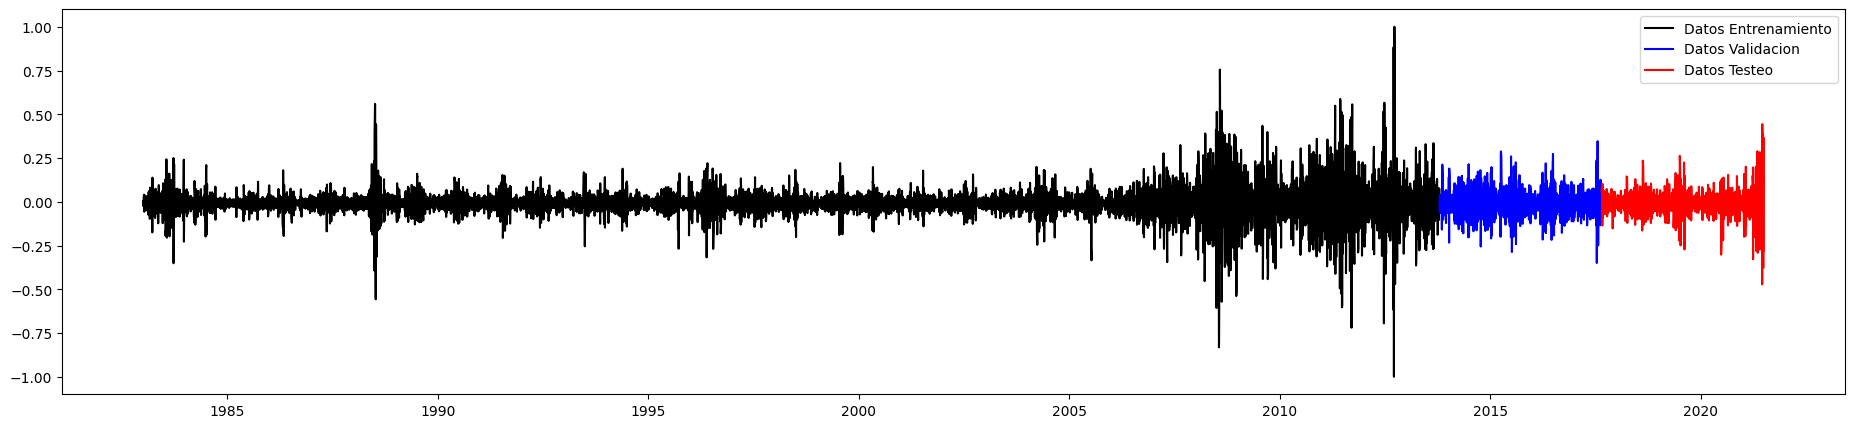

In [14]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [15]:

# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [16]:
def modeloRR_m1():
  modelo = Sequential()
  modelo.add(LSTM(units=10, input_shape=(1,10), activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.017), loss='mse')
  return modelo

In [17]:
modelo = modeloRR_m1()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 13s 6ms/step - loss: 0.0067
Epoch 2/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0064
Epoch 3/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0064
Epoch 4/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0064
Epoch 5/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0064
Epoch 6/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0064
Epoch 7/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0063
Epoch 8/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0064
Epoch 9/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0063
Epoch 10/40
1607/1607 [==============================] - 4s 3ms/step - loss: 0.0064
Epoch 11/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0064
Epoch 12/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.0064


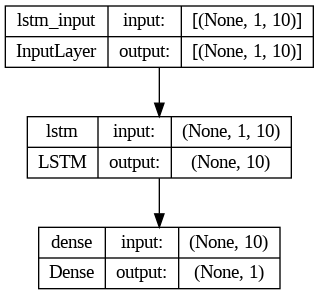

In [18]:
plot_model(modelo, to_file='modelo.png', show_shapes=True, show_layer_names=True)

In [19]:
prediccion_validacion_m1 = modelo.predict(X_val)
prediccion_testeo_m1 = modelo.predict(X_test)

44/44 [==============================] - 0s 3ms/step


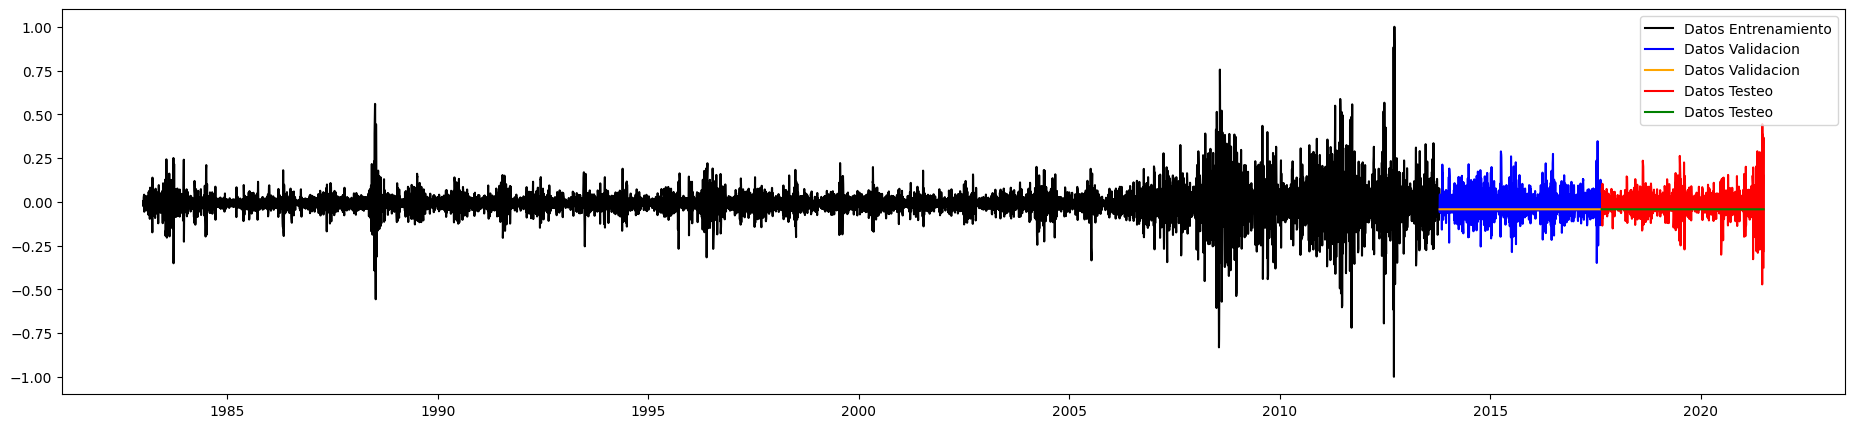

In [20]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m1.index,prediccion_validacion_m1,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m1.index,prediccion_testeo_m1,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

Esta actualmente en 0.078

In [21]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m1,datos_validacion_m1.Precio_Cierre))
print(score)

0.08648138


In [22]:
prediccion_validacion_m1 = modo_1_scaler.inverse_transform(prediccion_validacion_m1)
prediccion_testeo_m1 = modo_1_scaler.inverse_transform(prediccion_testeo_m1 )

#Modelamos Modo 2

In [23]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = create_features(modo_2_escalado)
modo_2_sup = add_lags(modo_2_sup)
modo_2_sup.dropna(inplace=True)
modo_2_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.188319,5,1,1,1983,1,1,52,0.167714,0.222971,0.307612
1983-01-02,0.180620,6,1,1,1983,2,2,52,0.160417,0.253188,0.237516
1983-01-03,0.172921,0,1,1,1983,3,3,1,0.153120,0.265889,0.166993
1983-01-04,0.148923,1,1,1,1983,4,4,1,0.145822,0.278589,0.154927
1983-01-05,0.130999,2,1,1,1983,5,5,1,0.157503,0.291290,0.142860


In [24]:
modo_2= pd.DataFrame(modo_2_scaler.inverse_transform(modo_2_sup),columns=modo_2_sup.columns,index=modo_2_sup.index)

In [25]:
total_datos=len(modo_2_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

datos_entrenamiento_m2_values= datos_entrenamiento_m2.values.astype('float32')
datos_validacion_m2_values = datos_validacion_m2.values.astype('float32')
datos_testeo_m2_values = datos_testeo_m2.values.astype('float32')

X_train, y_train = datos_entrenamiento_m2_values[:, :-1], datos_entrenamiento_m2_values[:, -1]
X_val, y_val = datos_validacion_m2_values[:, :-1], datos_validacion_m2_values[:, -1]
X_test, y_test = datos_testeo_m2_values[:, :-1], datos_testeo_m2_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


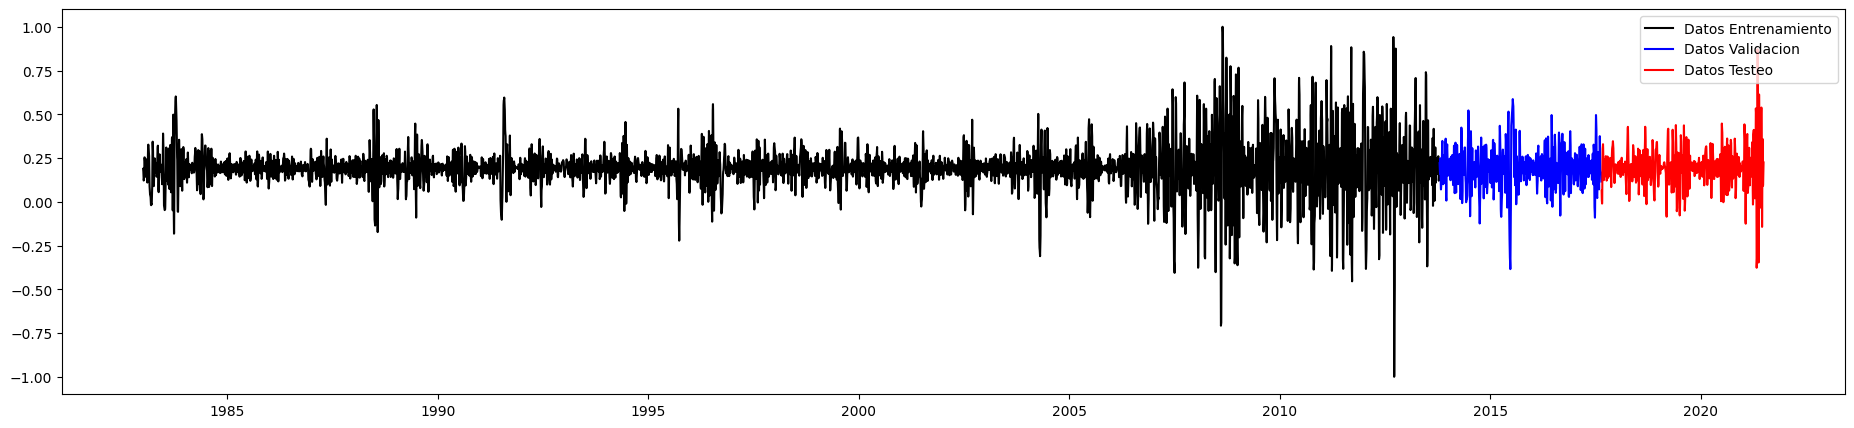

In [26]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [27]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [28]:
def modeloRR_m2():
  modelo = Sequential()
  modelo.add(LSTM(units=48, input_shape=(1,10), activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=12,  activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=46, activation='tanh',return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(0.0055), loss='mse')
  return modelo

In [29]:
modelo = modeloRR_m2()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 15s 6ms/step - loss: 0.0121
Epoch 2/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0118
Epoch 3/40
1607/1607 [==============================] - 10s 6ms/step - loss: 0.0118
Epoch 4/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0118
Epoch 5/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0118
Epoch 6/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0118
Epoch 7/40
1607/1607 [==============================] - 9s 5ms/step - loss: 0.0118
Epoch 8/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0118
Epoch 9/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0118
Epoch 10/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0118
Epoch 11/40
1607/1607 [==============================] - 9s 5ms/step - loss: 0.0118
Epoch 12/40
1607/1607 [==============================] - 9s 5ms/step - loss: 0.0118

In [30]:
prediccion_validacion_m2 = modelo.predict(X_val)
prediccion_testeo_m2 = modelo.predict(X_test)

44/44 [==============================] - 0s 4ms/step


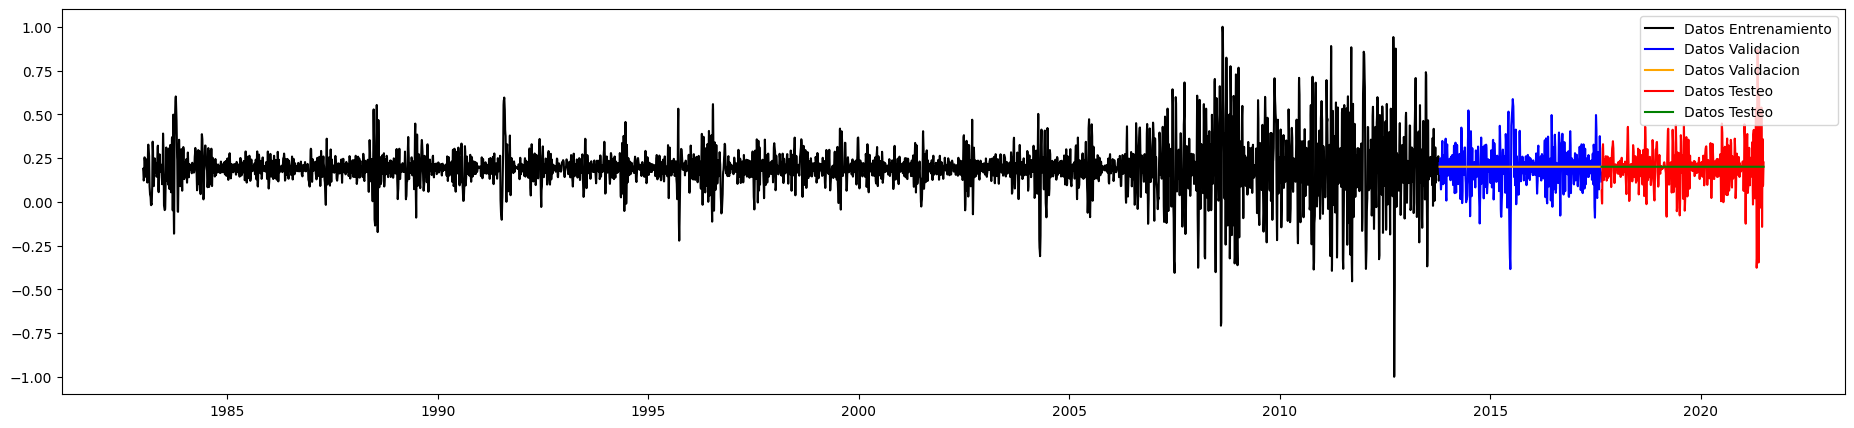

In [31]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m2.index,prediccion_validacion_m2,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m2.index,prediccion_testeo_m2,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

el score esta en 0.1254

In [32]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m2,datos_validacion_m2.Precio_Cierre))
print(score)

0.11755396


In [33]:
prediccion_validacion_m2 = modo_2_scaler.inverse_transform(prediccion_validacion_m2)
prediccion_testeo_m2 = modo_2_scaler.inverse_transform(prediccion_testeo_m2 )

# Modelamos modo 3

In [34]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = create_features(modo_3_escalado)
modo_3_sup = add_lags(modo_3_sup)
modo_3_sup.dropna(inplace=True)
modo_3_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.140801,5,1,1,1983,1,1,52,0.193082,0.059190,0.151156
1983-01-02,0.143270,6,1,1,1983,2,2,52,0.193951,0.067364,0.128091
1983-01-03,0.145740,0,1,1,1983,3,3,1,0.194819,0.073162,0.106627
1983-01-04,0.155028,1,1,1,1983,4,4,1,0.195688,0.078961,0.102951
1983-01-05,0.163749,2,1,1,1983,5,5,1,0.190044,0.084759,0.099274


In [35]:
modo_3= pd.DataFrame(modo_3_scaler.inverse_transform(modo_3_sup),columns=modo_3_sup.columns,index=modo_3_sup.index)

In [36]:
total_datos=len(modo_3_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

datos_entrenamiento_m3_values= datos_entrenamiento_m3.values.astype('float32')
datos_validacion_m3_values = datos_validacion_m3.values.astype('float32')
datos_testeo_m3_values = datos_testeo_m3.values.astype('float32')

X_train, y_train = datos_entrenamiento_m3_values[:, :-1], datos_entrenamiento_m3_values[:, -1]
X_val, y_val = datos_validacion_m3_values[:, :-1], datos_validacion_m3_values[:, -1]
X_test, y_test = datos_testeo_m3_values[:, :-1], datos_testeo_m3_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


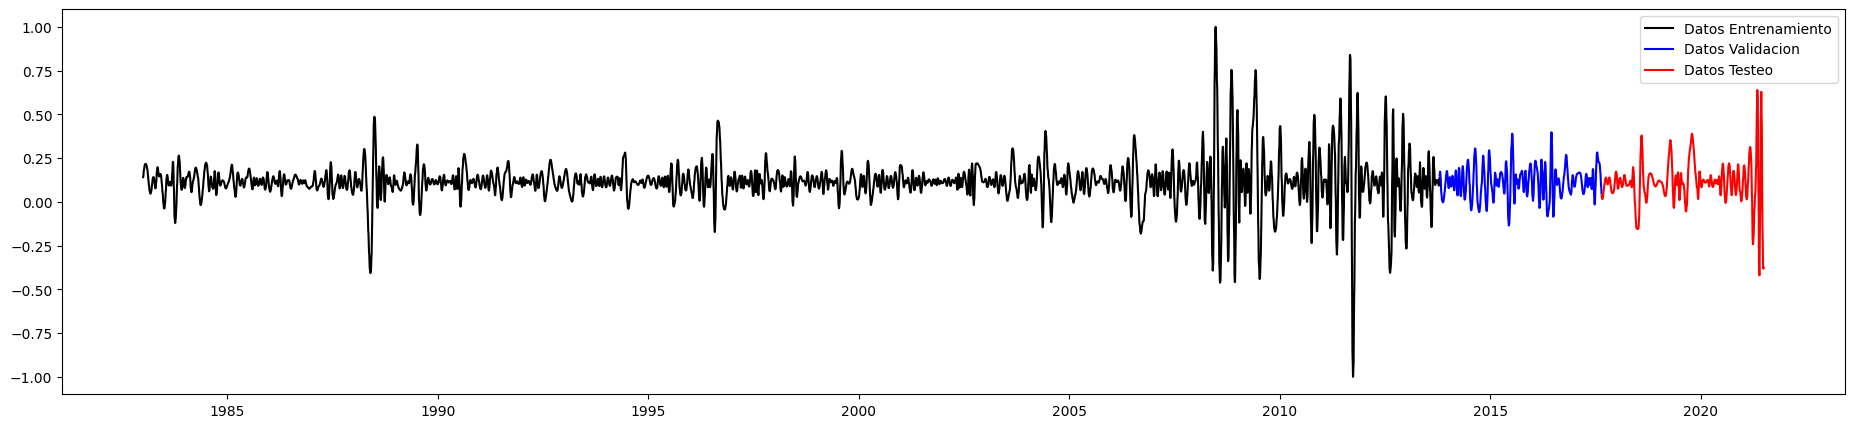

In [37]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [38]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [39]:
def modeloRR_m3():
  modelo = Sequential()
  modelo.add(LSTM(units=55, input_shape=(1,10), activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=57,  activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=44,  activation='tanh',return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(0.005), loss='mse')
  return modelo

In [40]:
modelo = modeloRR_m3()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 15s 6ms/step - loss: 0.0111
Epoch 2/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0110
Epoch 3/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0110
Epoch 4/40
1607/1607 [==============================] - 9s 5ms/step - loss: 0.0110
Epoch 5/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0110
Epoch 6/40
1607/1607 [==============================] - 10s 6ms/step - loss: 0.0110
Epoch 7/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0110
Epoch 8/40
1607/1607 [==============================] - 10s 6ms/step - loss: 0.0110
Epoch 9/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0110
Epoch 10/40
1607/1607 [==============================] - 9s 6ms/step - loss: 0.0110
Epoch 11/40
1607/1607 [==============================] - 10s 6ms/step - loss: 0.0110
Epoch 12/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.01

In [41]:
prediccion_validacion_m3 = modelo.predict(X_val)
prediccion_testeo_m3 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


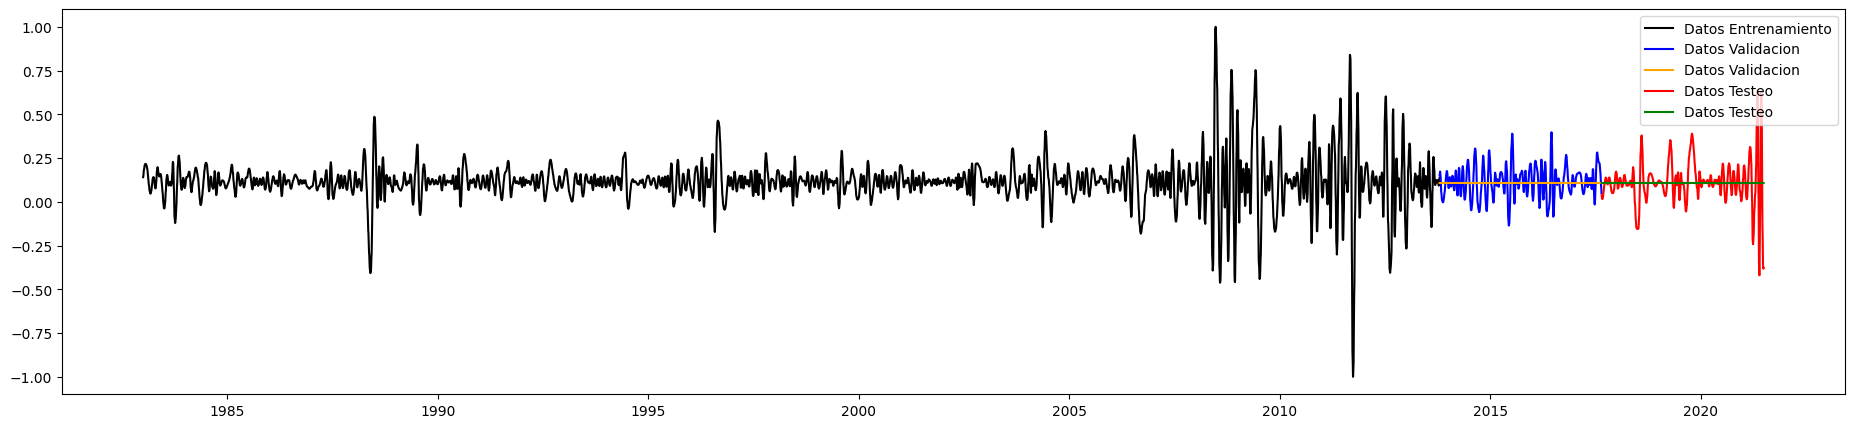

In [42]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m3.index,prediccion_validacion_m3,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m3.index,prediccion_testeo_m3,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [43]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m3,datos_validacion_m3.Precio_Cierre))
print(score)

0.08783974


In [44]:
prediccion_validacion_m3 = modo_3_scaler.inverse_transform(prediccion_validacion_m3)
prediccion_testeo_m3 = modo_3_scaler.inverse_transform(prediccion_testeo_m3 )

# modelamos modo 4


In [45]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = create_features(modo_4_escalado)
modo_4_sup = add_lags(modo_4_sup)
modo_4_sup.dropna(inplace=True)
modo_4_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,0.086861,5,1,1,1983,1,1,52,-0.049781,-0.074277,-0.039828
1983-01-02,0.087461,6,1,1,1983,2,2,52,-0.048311,-0.073692,-0.046625
1983-01-03,0.088060,0,1,1,1983,3,3,1,-0.046842,-0.073162,-0.052982
1983-01-04,0.090320,1,1,1,1983,4,4,1,-0.045372,-0.072632,-0.054141
1983-01-05,0.092455,2,1,1,1983,5,5,1,-0.039134,-0.072102,-0.055300


In [46]:
modo_4= pd.DataFrame(modo_4_scaler.inverse_transform(modo_4_sup),columns=modo_4_sup.columns,index=modo_4_sup.index)

In [47]:
total_datos=len(modo_4_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

datos_entrenamiento_m4_values= datos_entrenamiento_m4.values.astype('float32')
datos_validacion_m4_values = datos_validacion_m4.values.astype('float32')
datos_testeo_m4_values = datos_testeo_m4.values.astype('float32')

X_train, y_train = datos_entrenamiento_m4_values[:, :-1], datos_entrenamiento_m4_values[:, -1]
X_val, y_val = datos_validacion_m4_values[:, :-1], datos_validacion_m4_values[:, -1]
X_test, y_test = datos_testeo_m4_values[:, :-1], datos_testeo_m4_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


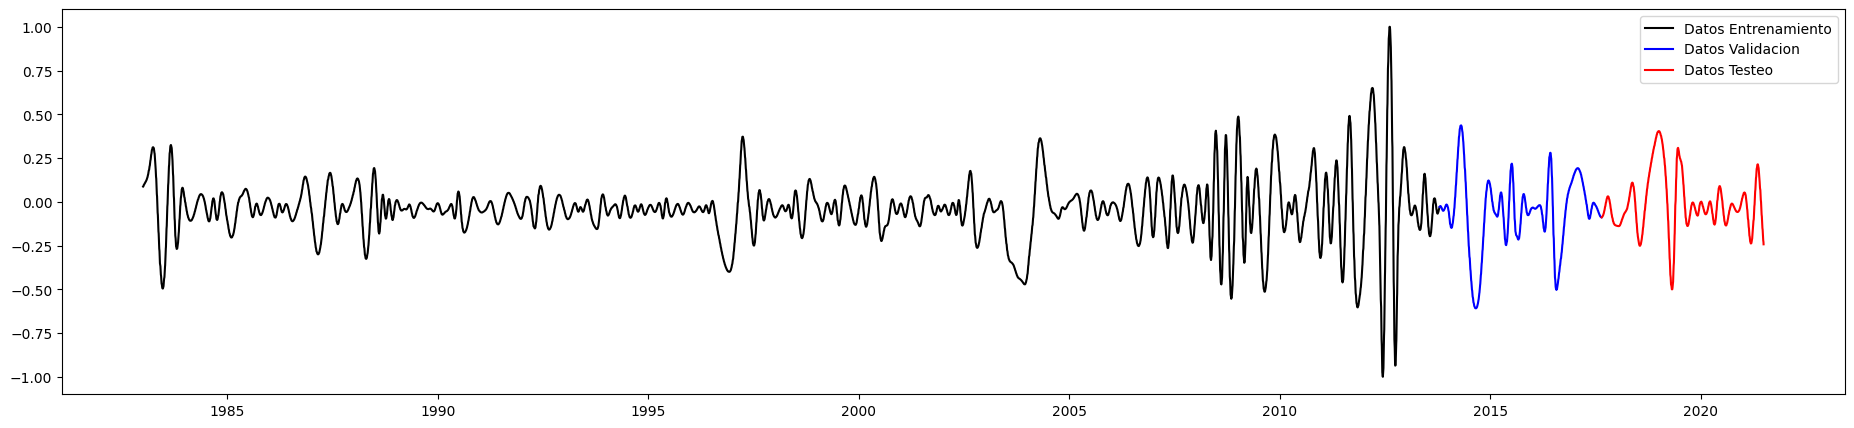

In [48]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [49]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [50]:
def modeloRR_m4():
  modelo = Sequential()
  modelo.add(LSTM(units=9, input_shape=(1,10), activation='tanh', return_sequences=True))
  modelo.add(LSTM(units=19, activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(0.0073), loss='mse')
  return modelo

In [51]:
modelo = modeloRR_m4()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 12s 5ms/step - loss: 0.0169
Epoch 2/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169
Epoch 3/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0169
Epoch 4/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0169
Epoch 5/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169
Epoch 6/40
1607/1607 [==============================] - 7s 5ms/step - loss: 0.0169
Epoch 7/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169
Epoch 8/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0169
Epoch 9/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169
Epoch 10/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0169
Epoch 11/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169
Epoch 12/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0169


In [52]:
modelo.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 9)              720       
                                                                 
 lstm_8 (LSTM)               (None, 19)                2204      
                                                                 
 dense_3 (Dense)             (None, 1)                 20        
                                                                 
Total params: 2944 (11.50 KB)
Trainable params: 2944 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
prediccion_validacion_m4 = modelo.predict(X_val)
prediccion_testeo_m4 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


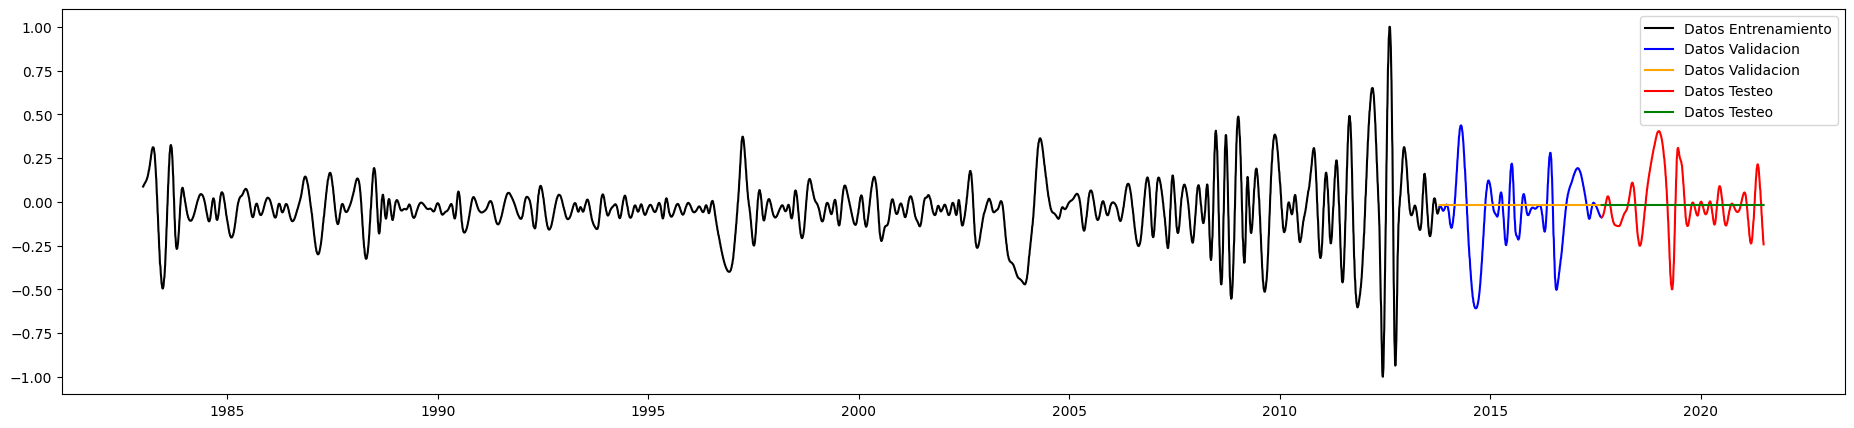

In [54]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m4.index,prediccion_validacion_m4,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m4.index,prediccion_testeo_m4,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

estamos en 0.2092

In [55]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m4,datos_validacion_m4.Precio_Cierre))
print(score)

0.21253511


In [56]:
prediccion_validacion_m4 = modo_4_scaler.inverse_transform(prediccion_validacion_m4)
prediccion_testeo_m4 = modo_4_scaler.inverse_transform(prediccion_testeo_m4 )

# Modelamos modo 5

In [57]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = create_features(modo_5_escalado)
modo_5_sup = add_lags(modo_5_sup)
modo_5_sup.dropna(inplace=True)
modo_5_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.211661,5,1,1,1983,1,1,52,-0.112336,-0.048832,0.106591
1983-01-02,-0.211620,6,1,1,1983,2,2,52,-0.111756,-0.049922,0.104982
1983-01-03,-0.211579,0,1,1,1983,3,3,1,-0.111176,-0.050620,0.103360
1983-01-04,-0.211387,1,1,1,1983,4,4,1,-0.110596,-0.051317,0.103032
1983-01-05,-0.211167,2,1,1,1983,5,5,1,-0.108179,-0.052015,0.102705


In [58]:
modo_5= pd.DataFrame(modo_5_scaler.inverse_transform(modo_5_sup),columns=modo_5_sup.columns,index=modo_5_sup.index)

In [59]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values.astype('float32')
datos_validacion_m5_values = datos_validacion_m5.values.astype('float32')
datos_testeo_m5_values = datos_testeo_m5.values.astype('float32')

X_train, y_train = datos_entrenamiento_m5_values[:, :-1], datos_entrenamiento_m5_values[:, -1]
X_val, y_val = datos_validacion_m5_values[:, :-1], datos_validacion_m5_values[:, -1]
X_test, y_test = datos_testeo_m5_values[:, :-1], datos_testeo_m5_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


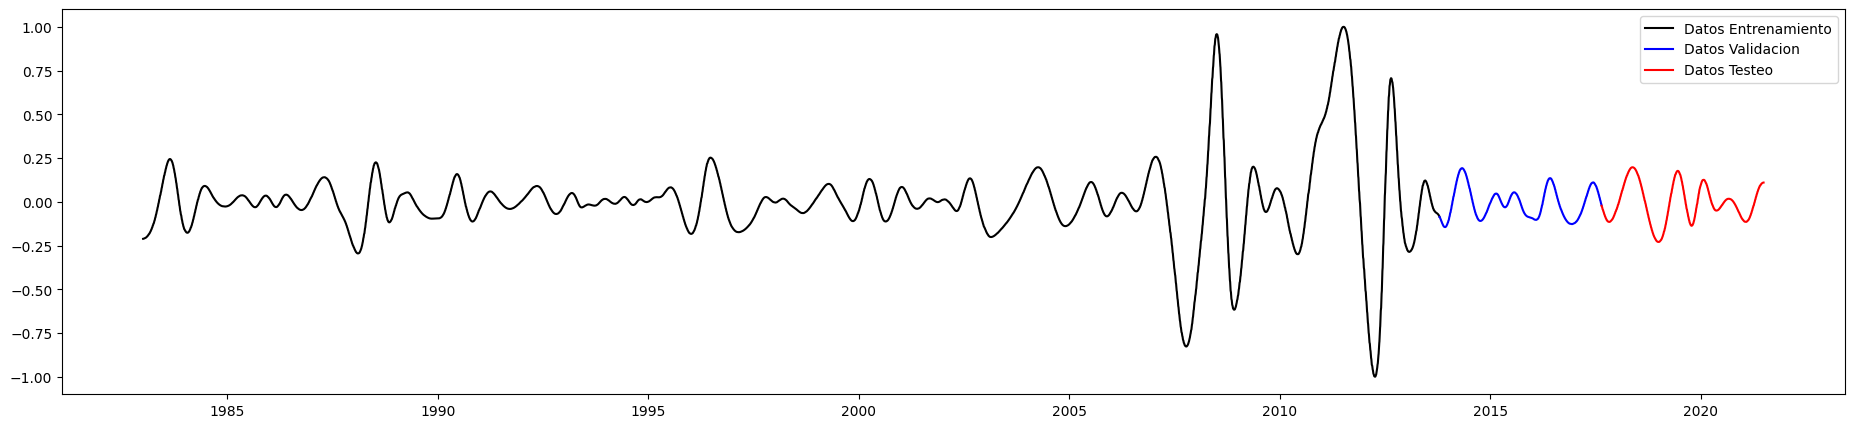

In [60]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [61]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [62]:
def modeloRR_m5():
  modelo = Sequential()
  modelo.add(LSTM(units=28, input_shape=(1,10), activation='tanh',return_sequences=True))
  modelo.add(LSTM(units=59, activation='tanh',return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop( 0.061), loss='mse')
  return modelo

In [63]:
modelo = modeloRR_m5()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 12s 5ms/step - loss: 0.0373
Epoch 2/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0301
Epoch 3/40
1607/1607 [==============================] - 7s 5ms/step - loss: 0.0301
Epoch 4/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0300
Epoch 5/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0300
Epoch 6/40
1607/1607 [==============================] - 7s 4ms/step - loss: 0.0300
Epoch 7/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0300
Epoch 8/40
1607/1607 [==============================] - 7s 5ms/step - loss: 0.0301
Epoch 9/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0300
Epoch 10/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0300
Epoch 11/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0301
Epoch 12/40
1607/1607 [==============================] - 8s 5ms/step - loss: 0.0299


In [64]:
prediccion_validacion_m5 = modelo.predict(X_val)
prediccion_testeo_m5 = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


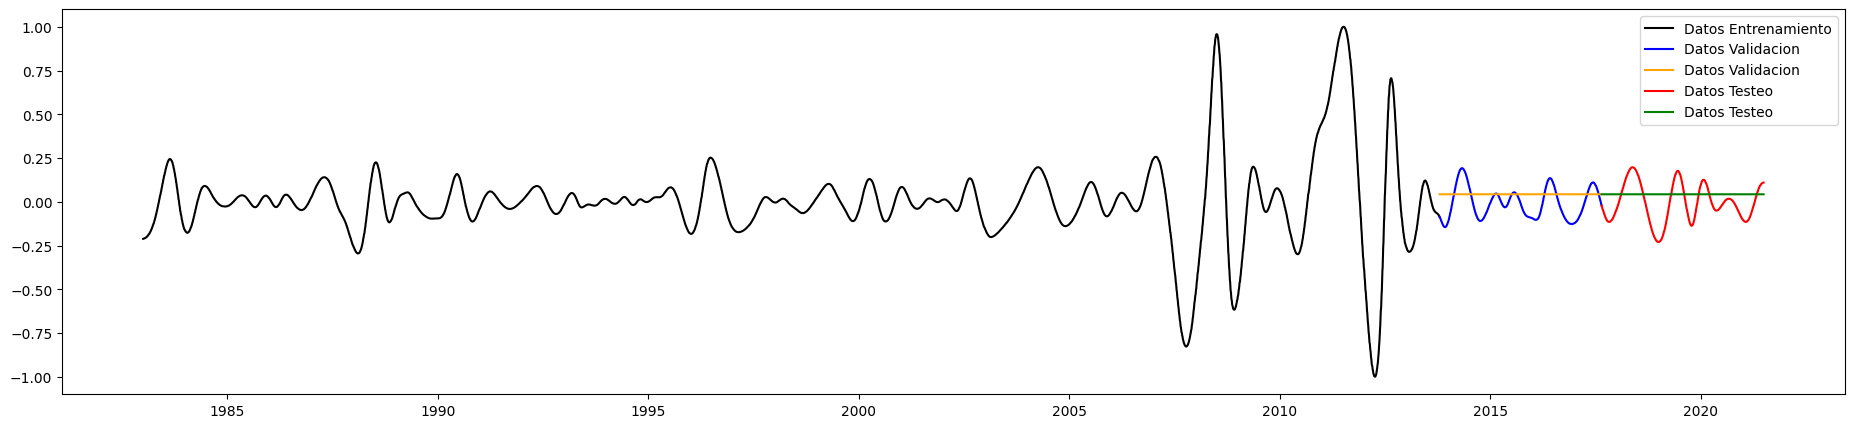

In [65]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,prediccion_validacion_m5,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_testeo_m5,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

nota: estaba en 0.013 antes

In [66]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m5,datos_validacion_m5.Precio_Cierre))
print(score)

0.10108412


In [67]:
prediccion_validacion_m5 = modo_5_scaler.inverse_transform(prediccion_validacion_m5)
prediccion_testeo_m5 = modo_5_scaler.inverse_transform(prediccion_testeo_m5 )

# Modelamos Residuo

In [68]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = create_features(residuo_escalado)
residuo_sup = add_lags(residuo_sup)
residuo_sup.dropna(inplace=True)
residuo_sup.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1983-01-01,-0.521621,5,1,1,1983,1,1,52,-0.458435,-0.175241,-0.500525
1983-01-02,-0.521433,6,1,1,1983,2,2,52,-0.458852,-0.174871,-0.499712
1983-01-03,-0.521244,0,1,1,1983,3,3,1,-0.459269,-0.174631,-0.498891
1983-01-04,-0.520489,1,1,1,1983,4,4,1,-0.459687,-0.174390,-0.498725
1983-01-05,-0.519731,2,1,1,1983,5,5,1,-0.461346,-0.174149,-0.498560


In [69]:
residuo= pd.DataFrame(residuo_scaler.inverse_transform(residuo_sup),columns=residuo_sup.columns,index=residuo_sup.index)


In [70]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values.astype('float32')
datos_validacion_residuo_values = datos_validacion_residuo.values.astype('float32')
datos_testeo_residuo_values = datos_testeo_residuo.values.astype('float32')

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(11248, 1, 10) (11248,) (1406, 1, 10) (1406,) (1406, 1, 10) (1406,)


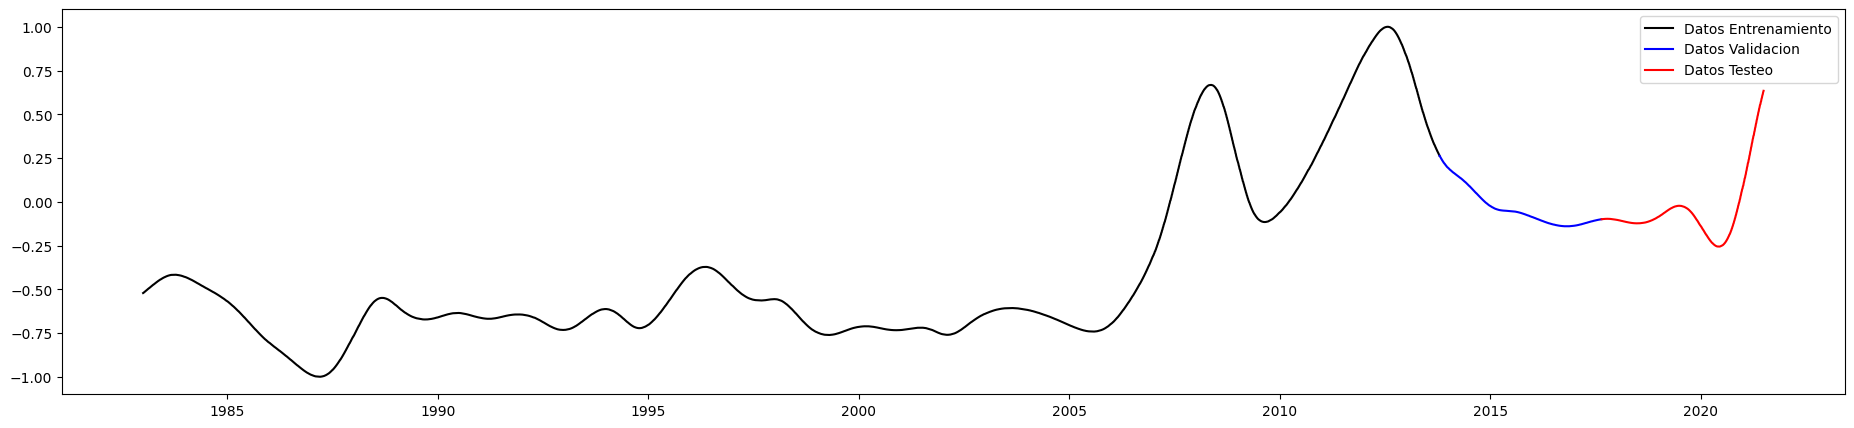

In [71]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [72]:
# Crear un estudio Optuna
#study = optuna.create_study(direction='minimize')

# Ejecutar la optimización de hiperparámetros
#study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
#best_params = study.best_params
#print("Mejores hiperparámetros:", best_params)

In [91]:
#Este modelo me esta dando un RECM de 0.009257653
def modeloRR_residuo():
  modelo = Sequential()
  modelo.add(LSTM(units=10, input_shape=(1,10), activation='tanh', return_sequences=False))
  #modelo.add(LSTM(units=44, activation='tanh', return_sequences=False))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(  0.079), loss='mse')
  return modelo

In [92]:
modelo = modeloRR_residuo()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1607/1607 [==============================] - 9s 3ms/step - loss: 0.1177
Epoch 2/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1178
Epoch 3/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1171
Epoch 4/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.1180
Epoch 5/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1177
Epoch 6/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1174
Epoch 7/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.1171
Epoch 8/40
1607/1607 [==============================] - 5s 3ms/step - loss: 0.1167
Epoch 9/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1167
Epoch 10/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1166
Epoch 11/40
1607/1607 [==============================] - 6s 4ms/step - loss: 0.1166
Epoch 12/40
1607/1607 [==============================] - 4s 2ms/step - loss: 0.1174
E

In [93]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

44/44 [==============================] - 0s 2ms/step


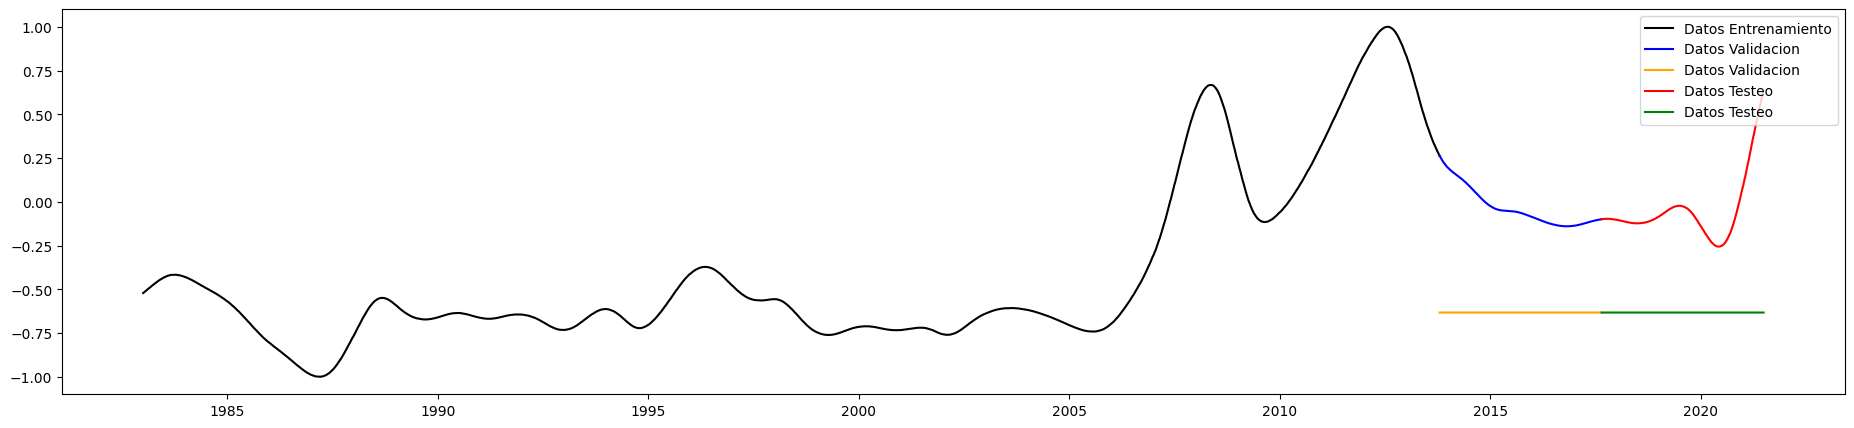

In [94]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [95]:
score = np.sqrt(mean_squared_error(prediccion_validacion_residuo,datos_validacion_residuo.Precio_Cierre))
print(score)

0.61077654


In [96]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [82]:
datos_emd = modo_1.Precio_Cierre + modo_2.Precio_Cierre +modo_3.Precio_Cierre + modo_4.Precio_Cierre + modo_5.Precio_Cierre + residuo.Precio_Cierre
datos_emd = datos_emd.to_frame()

In [83]:

validacion = prediccion_validacion_m1 + prediccion_validacion_m2 + prediccion_validacion_m3 + prediccion_validacion_m4 + prediccion_validacion_m5 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m1 + prediccion_testeo_m2 +prediccion_testeo_m3 +prediccion_testeo_m4 + prediccion_testeo_m5 + prediccion_testeo_residuo

In [84]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [86]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre)
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 123.36763609073726 
el error absoluto medio del modelo es: 118.17231352081666 
Error porcentual absoluto medio del modelo es: 0.4048084339638705


In [87]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( testeo,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 126.80266305295385 
el error absoluto medio del modelo es: 117.34701139975616 
Error porcentual absoluto medio del modelo es: 0.40198129747800726


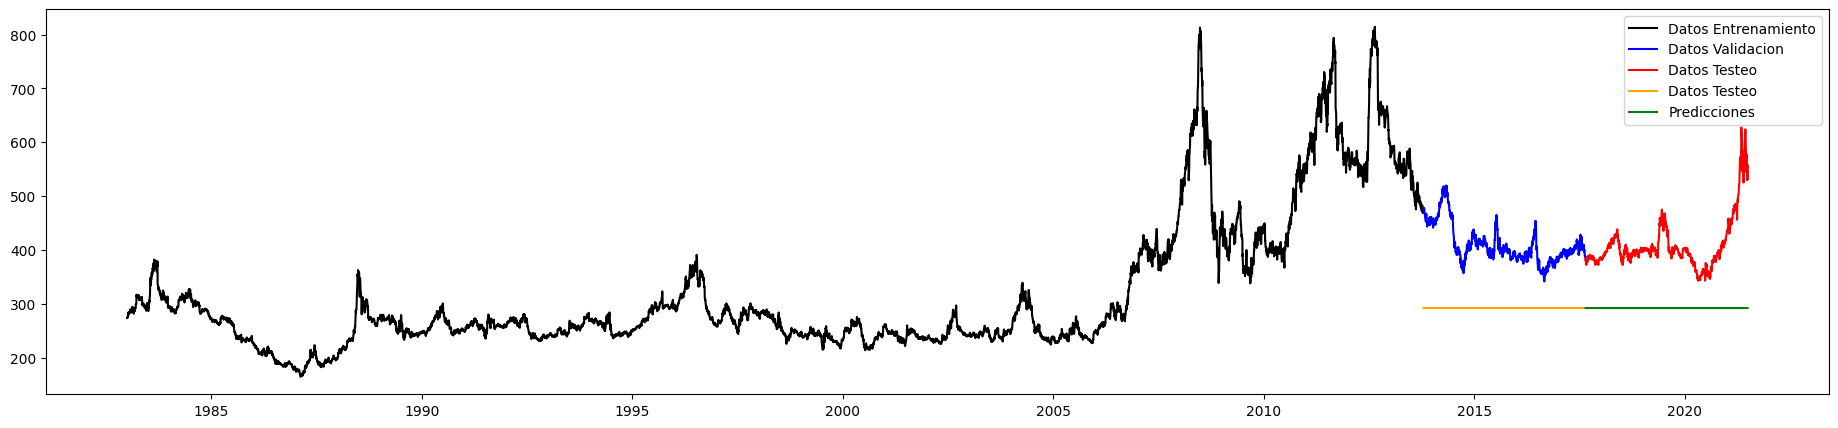

In [89]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

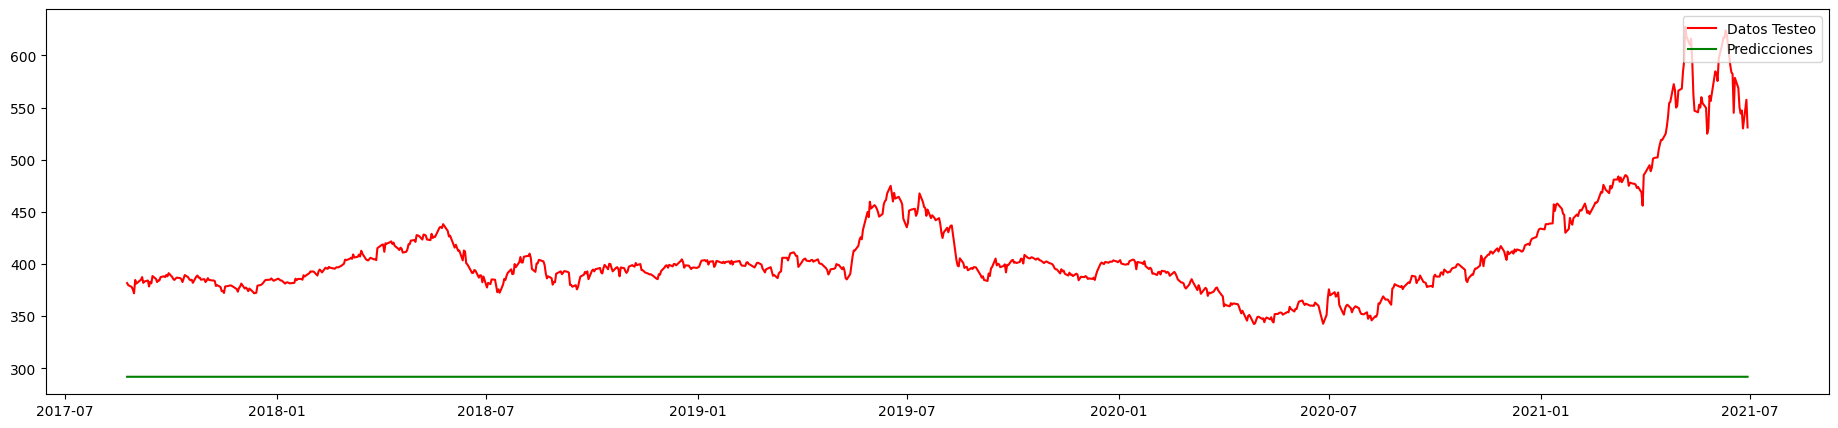

In [90]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()